# FISH integrated analyses

<img src= /home/luisub/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

<img src= /Users/luisaguilera/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

## Libraries

In [1]:
# Importing libraries
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
import os
import shutil
warnings.filterwarnings("ignore")

## Directories Path

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
# Path
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('GAPDH_Exon_Cy5_short')     # path to a folder with images.
#data_dir = current_dir.joinpath('temp_MS2-CY5-6minTPL')     # path to a folder with images.
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('DUSP1_Cy5_norm_fbs_wo_DEX')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('DUSP1_Cy5_norm_fbs_DEX_100nM_120min')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('DUSP1_Cy5_DEX_5min_a')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('HeLa_Anxa1_WO_DEX_0min_Goldmedia')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('RPE_GoldFBS_ANXA_DEX_120min')
data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('test')
masks_dir = current_dir.joinpath('masks_test') # None # pathlib.Path('Test','masks')

folder_name = data_dir.name
merge_images = 0 # this flag indicates if the images need to be merged

# Segmentation
channels_with_cytosol = [1,2]            # list or int indicating the channels where the cytosol is detectable
channels_with_nucleus =0                # list or int indicating the channels where the nucleus is detectable
channels_with_FISH = [1]               # list or int with the channels with FISH spots that are used for the quantification

diamter_nucleus = 100#100                    # approximate nucleus size in pixels
diameter_cytosol = 200#250              # approximate cytosol size in pixels

# Parameters for spot detection
voxel_size_z = 500                       # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103                      # Microscope conversion px to nanometers in the xy axis.

psf_z_type_0 = 300                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx_type_0 = 120                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.

psf_z_type_1 = 300                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx_type_1 = 110                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.

list_voxels = [ [voxel_size_z, voxel_size_yx  ] ,  [voxel_size_z,voxel_size_yx ] ]
list_psfs = [ [psf_z_type_0 ,psf_yx_type_0] , [psf_z_type_1,psf_yx_type_1] ]

# Cluster Detection
minimum_spots_cluster = 2                # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots=True                          # Flag to display plots

optimization_segmentation_method = 'z_slice_segmentation' # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , None

In [4]:
# Detecting if images need to be merged
is_needed_to_merge_images = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).checking_images()
if is_needed_to_merge_images == True:
    list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    data_dir = data_dir.joinpath('merged')

 ___ __  __    _    ____ _____        ___  
|_ _|  \/  |  / \  / ___| ____|  _   / _ \ 
 | || |\/| | / _ \| |  _|  _|   (_) | | | |
 | || |  | |/ ___ \ |_| | |___   _  | |_| |
|___|_|  |_/_/   \_\____|_____| (_)  \___/ 
                                           

ORIGINAL IMAGE
ROI008_XY1620756343_Z00_T0_merged.tif
(25, 928, 624, 3)


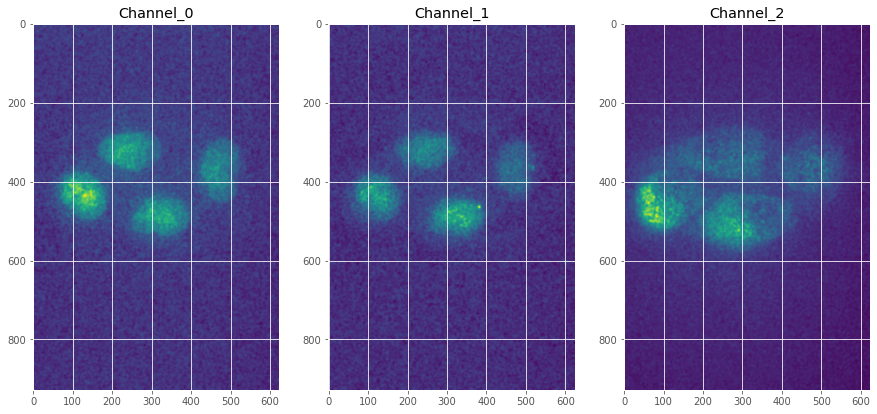

CELL SEGMENTATION


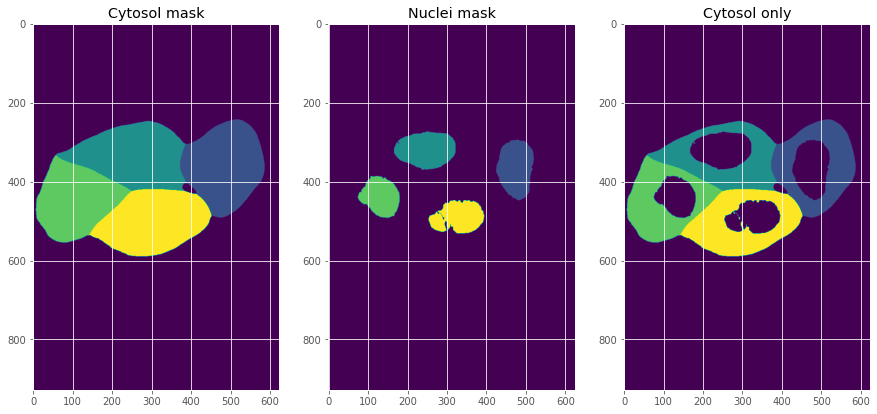

SPOT DETECTION
Spot Detection for Channel : 1
not showing elbow plot
Z-Slice:  12


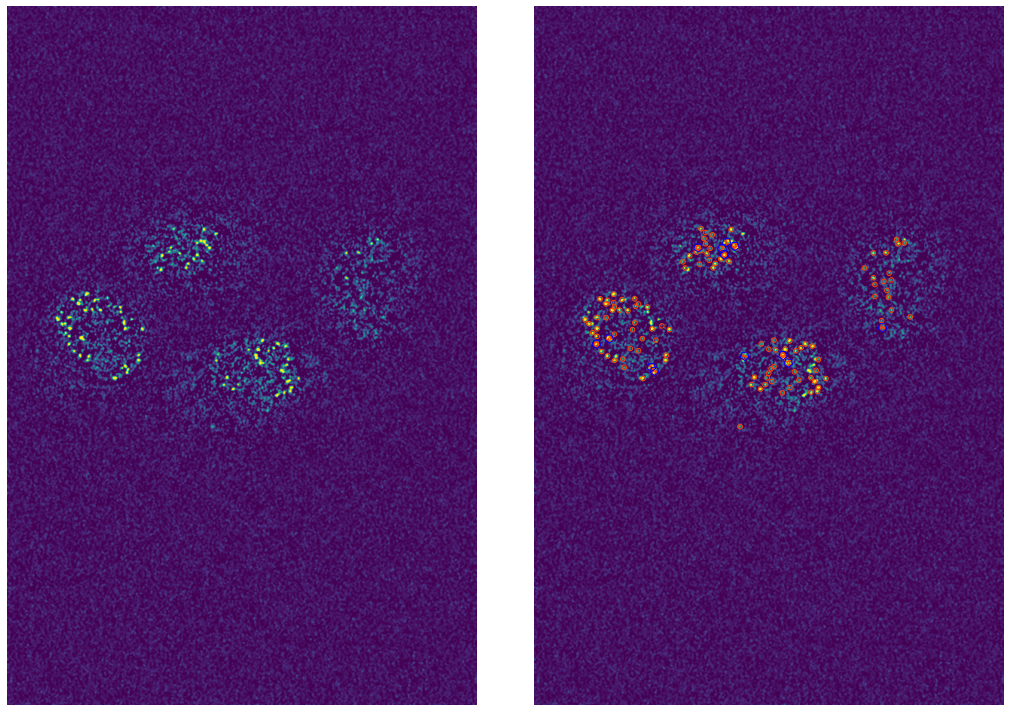

sh: 1: touch./metadata_test.txt: not found


In [5]:
dataframe_FISH, list_masks_complete_cells, list_masks_nuclei, list_masks_cytosol_no_nuclei = fa.PipelineFISH(data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diamter_nucleus, diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  list_voxels=list_voxels, list_psfs=list_psfs, show_plot=show_plots,file_name_str =folder_name,optimization_segmentation_method = optimization_segmentation_method ).run()

In [6]:
#dataframe_FISH.head()

In [7]:
# Number of cells
spot_type_selected = 0

number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i)  & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]

# Number of spots in cytosol
number_of_spots_per_cell_cytosol = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) & (dataframe_FISH['is_nuc']==False) & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]

# Number of spots in nucleus
number_of_spots_per_cell_nucleus = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected)    ].spot_id) for i in range(0, number_cells)]

# Number of TS per cell.
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['cluster_size'] >=4) ].spot_id) for i in range(0, number_cells)]
#number_of_TS_per_cell= np.asarray(number_of_TS_per_cell)
#number_of_TS_per_cell=number_of_TS_per_cell[number_of_TS_per_cell>0]   
    
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==spot_type_selected)   ].cluster_size.values

# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values

4


In [8]:
# Plotting intensity distributions
plt.style.use('ggplot')  # ggplot  #default
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
  n, bins, patches = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
  plt.title(title, size=16)
  return (f)

<Figure size 432x288 with 0 Axes>

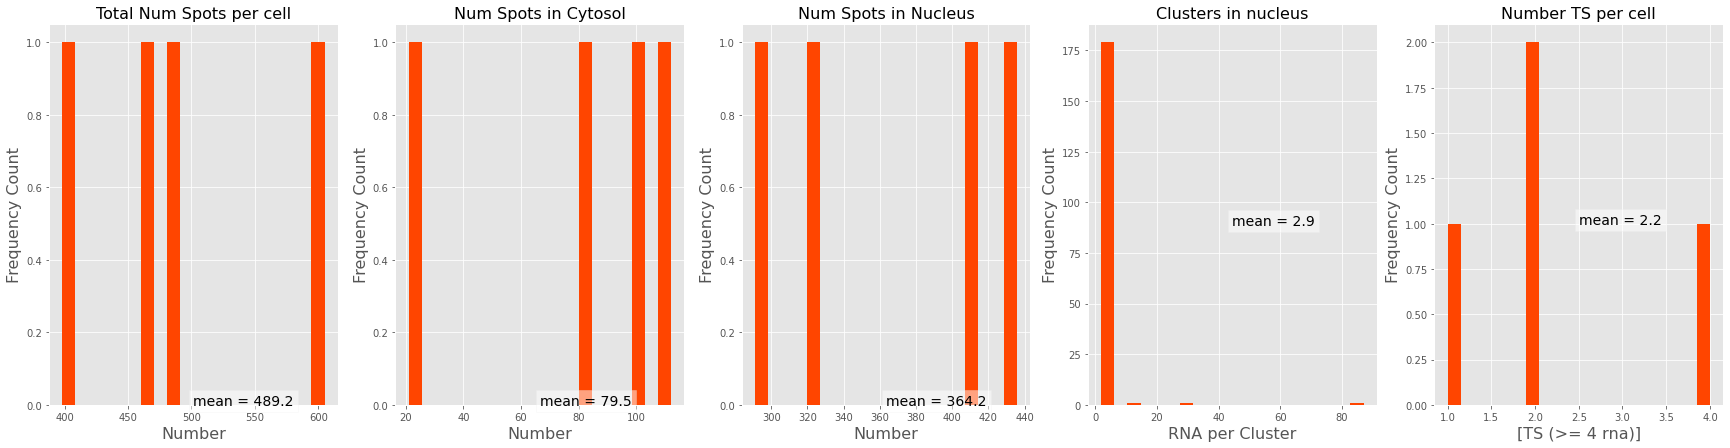

In [9]:
#Plotting
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)
#ylab='Probability'
ylab='Frequency Count'  
# adding subplots
f.add_subplot(1,5,1) 
plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,2) 
plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,3) 
plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,4) 
plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,5) 
plot_probability_distribution(number_of_TS_per_cell ,  numBins=20, title='Number TS per cell', xlab='[TS (>= 4 rna)]', ylab=ylab, fig=f, color='orangered')
plt.savefig('plots_'+folder_name)
plt.show()

In [10]:
# create results folder
if not os.path.exists(str('analysis_'+ folder_name)):
    os.makedirs(str('analysis_'+ folder_name))

#figure_path 
pathlib.Path().absolute().joinpath('plots_'+ folder_name +'.png').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ folder_name),'plots_'+ folder_name +'.png'))
#metadata_path
pathlib.Path().absolute().joinpath('metadata_'+ folder_name +'.txt').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ folder_name),'metadata_'+ folder_name +'.txt'))
#dataframe_path 
pathlib.Path().absolute().joinpath('dataframe_' + folder_name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ folder_name),'dataframe_'+ folder_name +'.csv'))
#pdf_path 
pathlib.Path().absolute().joinpath('pdf_report_' + folder_name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ folder_name),'pdf_report_'+ folder_name +'.pdf'))

# making a zip file
#shutil.make_archive(str('analysis_'+ folder_name),'zip',pathlib.Path().absolute().joinpath(str('analysis_'+ folder_name)))

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks/analysis_test/pdf_report_test.pdf')

In [11]:
#shutil.rmtree(str('analysis_'+ folder_name))
temp_results_folder_name = pathlib.Path().absolute().joinpath('temp_results_' + folder_name)
shutil.rmtree(temp_results_folder_name)
#os.remove(pathlib.Path().absolute().joinpath(str('analysis_'+ folder_name)+'.zip'))